# Historical forecast plotting
<!-- markdownlint-disable MD013 -->
Plotting historical forecasts to compare:

- The first time (issue time) a forecasted track enters the ZMA (i.e., the earliest time we could trigger)
- The time the storm makes landfall (i.e., the time we really care about)

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [28]:
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

from src.datasources import nhc, imerg, codab, zma
from src.constants import *

## Load data

In [3]:
blob_name = blob_name = (
    f"{PROJECT_PREFIX}/processed/nhc/monitors_nhc_chirpsgefs.parquet"
)
df_monitors = stratus.load_parquet_from_blob(blob_name)

In [4]:
filename = "temp/ibtracs.NA.list.v04r01.csv"
df_ibtracs = pd.read_csv(filename, skiprows=[1])

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_55182/2504498595.py:2: DtypeWarning: Columns (3,19,20,23,24,40,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ibtracs = pd.read_csv(filename, skiprows=[1])


In [5]:
df_storms = (
    df_ibtracs.groupby("SID")[["NAME", "USA_ATCF_ID"]].last().reset_index()
)
df_storms = df_storms.rename(
    columns={"SID": "sid", "NAME": "name", "USA_ATCF_ID": "atcf_id"}
)
df_storms = df_storms[df_storms["sid"].str[:4].astype(int) >= 2000]
df_storms["atcf_id"] = df_storms["atcf_id"].str.lower()

In [8]:
gdf_zma = zma.load_zma()

In [9]:
adm0 = codab.load_codab_from_blob()

In [60]:
adm0_buffer = gpd.GeoDataFrame(
    geometry=adm0.simplify(0.01).to_crs(3857).buffer(100_000).to_crs(4326)
)

In [61]:
gdf_nhc = nhc.load_historical_forecasts(include_geometry=True)

## Process data

In [139]:
# get points inside ZMA and making landfall
gdf_nhc["in_zma"] = gdf_nhc.within(gdf_zma.iloc[0].geometry)
gdf_nhc["landfall"] = gdf_nhc.within(adm0.iloc[0].geometry)

In [140]:
gdf_nhc = gdf_nhc.merge(df_storms, how="left")

In [141]:
gdf_nhc["season"] = gdf_nhc["valid_time"].dt.year

In [142]:
gdf_nhc["name_season"] = (
    gdf_nhc["name"].str.capitalize() + " " + gdf_nhc["season"].astype(str)
)

In [143]:
# observational is just the forecast at lt=0
gdf_obsv = gdf_nhc[gdf_nhc["issue_time"] == gdf_nhc["valid_time"]]

In [144]:
gdf_obsv[gdf_obsv["sid"] == RAFAEL]

,issue_time,valid_time,lat,lon,windspeed,pressure,atcf_id,geometry,in_zma,landfall,sid,name,season,name_season
78255,2024-11-03 18:00:00,2024-11-03 18:00:00,12.7,-77.1,30,0,al182024,POINT (-77.1 12.7),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78267,2024-11-04 00:00:00,2024-11-04 00:00:00,13.0,-76.9,30,0,al182024,POINT (-76.9 13),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78279,2024-11-04 06:00:00,2024-11-04 06:00:00,13.9,-76.9,30,0,al182024,POINT (-76.9 13.9),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78291,2024-11-04 12:00:00,2024-11-04 12:00:00,14.8,-76.7,30,0,al182024,POINT (-76.7 14.8),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78303,2024-11-04 18:00:00,2024-11-04 18:00:00,15.1,-76.4,40,0,al182024,POINT (-76.4 15.1),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78315,2024-11-05 00:00:00,2024-11-05 00:00:00,15.8,-76.9,40,0,al182024,POINT (-76.9 15.8),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78327,2024-11-05 06:00:00,2024-11-05 06:00:00,16.6,-77.7,45,0,al182024,POINT (-77.7 16.6),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78339,2024-11-05 12:00:00,2024-11-05 12:00:00,17.4,-78.2,50,0,al182024,POINT (-78.2 17.4),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78351,2024-11-05 18:00:00,2024-11-05 18:00:00,18.6,-79.1,55,0,al182024,POINT (-79.1 18.6),False,False,2024309N13283,RAFAEL,2024,Rafael 2024
78363,2024-11-06 00:00:00,2024-11-06 00:00:00,19.4,-79.9,70,0,al182024,POINT (-79.9 19.4),False,False,2024309N13283,RAFAEL,2024,Rafael 2024


In [145]:
# interpolating observational to make sure we get the right landfall time
dfs_interp = []
str_cols = ["atcf_id", "sid", "name", "season", "name_season"]
interp_cols = ["windspeed", "lat", "lon"]
for sid, group in gdf_obsv.groupby("sid"):
    group = group.sort_values("valid_time").set_index("valid_time")
    group_resampled = group.drop(columns="geometry").resample("30min").asfreq()
    group_resampled = group_resampled[interp_cols].interpolate().reset_index()
    # group_resampled[str_cols] = group.iloc[0][str_cols]
    for col in str_cols:
        group_resampled[col] = group.iloc[0][col]
    dfs_interp.append(group_resampled)

In [147]:
df_obsv_interp = pd.concat(dfs_interp, ignore_index=True)

In [148]:
gdf_obsv_interp = gpd.GeoDataFrame(
    data=df_obsv_interp,
    geometry=gpd.points_from_xy(df_obsv_interp["lon"], df_obsv_interp["lat"]),
    crs=4326,
)

In [150]:
# have to re-check landfall and ZMA after interpolating
gdf_obsv_interp["in_zma"] = gdf_obsv_interp.within(gdf_zma.iloc[0].geometry)
gdf_obsv_interp["landfall"] = gdf_obsv_interp.within(adm0.iloc[0].geometry)

## Plotting

In [151]:
def format_timedelta(td: pd.Timedelta) -> str:
    days = td.days
    hours = td.components.hours
    if days and hours:
        return f"{days} days, {hours} hours"
    elif days:
        return f"{days} days"
    else:
        return f"{hours} hours"

In [152]:
lonmin, latmin, lonmax, latmax = gdf_zma.total_bounds

In [189]:
def plot_sid_leadtime(sid):
    # filter by SID
    gdf_nhc_sid = gdf_nhc[gdf_nhc["sid"] == sid]

    # get earliest "triggering" forecast
    issue_time = gdf_nhc_sid[gdf_nhc_sid["in_zma"]]["issue_time"].min()
    gdf_issuetime = gdf_nhc_sid[gdf_nhc_sid["issue_time"] == issue_time]

    # get landfall time
    gdf_obsv_sid = gdf_obsv_interp[gdf_obsv_interp["sid"] == sid]
    landfall_time = gdf_obsv_sid[gdf_obsv_sid["landfall"]]["valid_time"].min()

    # filter observational to plot, otherwise plot is super zoomed out
    gdf_obsv_sid_plot = gdf_obsv_sid[
        (gdf_obsv_sid["lon"] >= lonmin - 1)
        & (gdf_obsv_sid["lat"] <= latmax + 1)
        & (gdf_obsv_sid["lat"] >= gdf_issuetime["lat"].min() - 1)
        & (gdf_obsv_sid["lon"] <= gdf_issuetime["lon"].max() + 1)
    ]

    leadtime = landfall_time - issue_time
    leadtime_str = format_timedelta(leadtime)

    fig, ax = plt.subplots(dpi=200, figsize=(10, 10))

    adm0.boundary.plot(color="grey", linewidth=0.5, ax=ax)
    gdf_zma.boundary.plot(color="grey", linewidth=0.5, ax=ax, linestyle="--")

    fcast_color = "darkorange"
    obsv_color = "crimson"

    gdf_issuetime.drop(columns="geometry").plot(
        x="lon",
        y="lat",
        ax=ax,
        color=fcast_color,
        label="forecast",
        linewidth=0.5,
    )

    for _, row in gdf_issuetime.iterrows():
        ax.annotate(
            row["windspeed"],
            (row["lon"], row["lat"]),
            fontsize=10,
            va="center",
            ha="center",
            color=fcast_color,
            fontweight="bold",
        )

    gdf_obsv_sid_plot.drop(columns="geometry").plot(
        x="lon",
        y="lat",
        ax=ax,
        label="actual",
        color=obsv_color,
        linewidth=0.5,
    )

    landfall_row = gdf_obsv_sid_plot.set_index("valid_time").loc[landfall_time]
    ax.annotate(
        f'{landfall_row["windspeed"]:.0f}',
        (landfall_row["lon"], landfall_row["lat"]),
        fontsize=10,
        va="center",
        ha="center",
        color=obsv_color,
        fontweight="bold",
    )

    ax.set_title(
        f'{gdf_issuetime.iloc[0]["name_season"]}: forecast issued {issue_time}\n'
        f"Landfall at {landfall_time}\n"
        f"Leadtime to landfall: {leadtime_str}"
    )

    ax.legend(title="Track and\nwind speed (knots)")

    ax.axis("off")

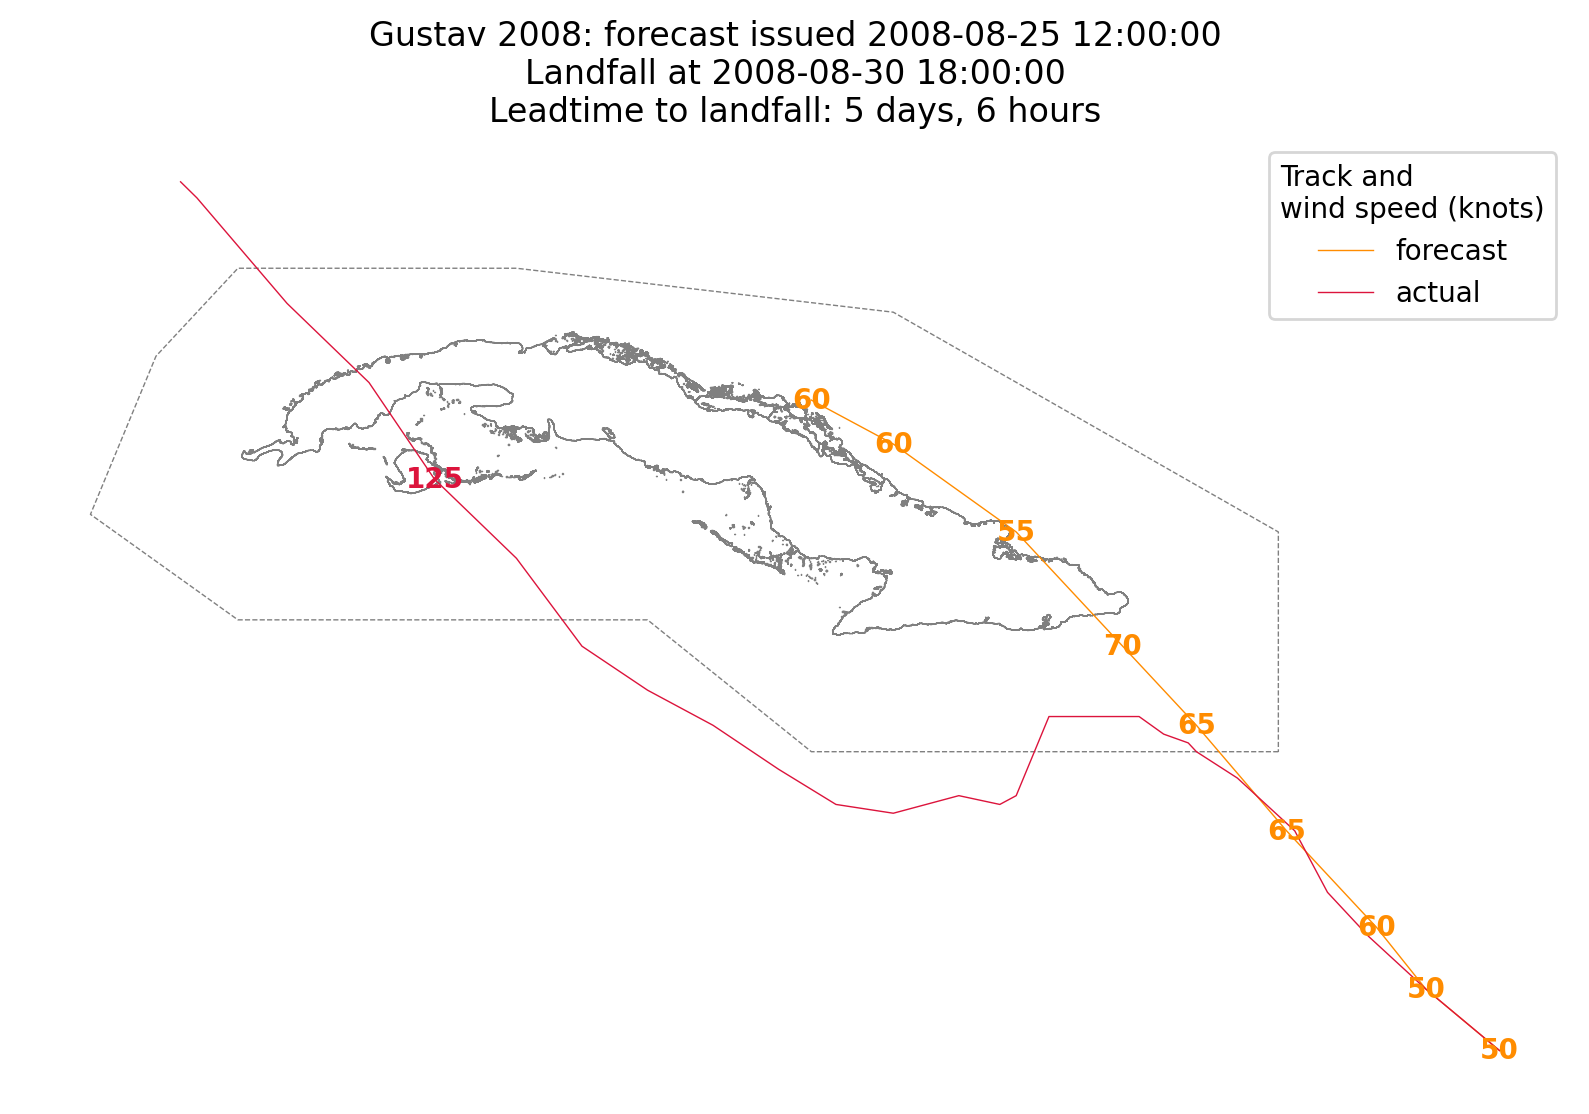

In [190]:
plot_sid_leadtime(GUSTAV)

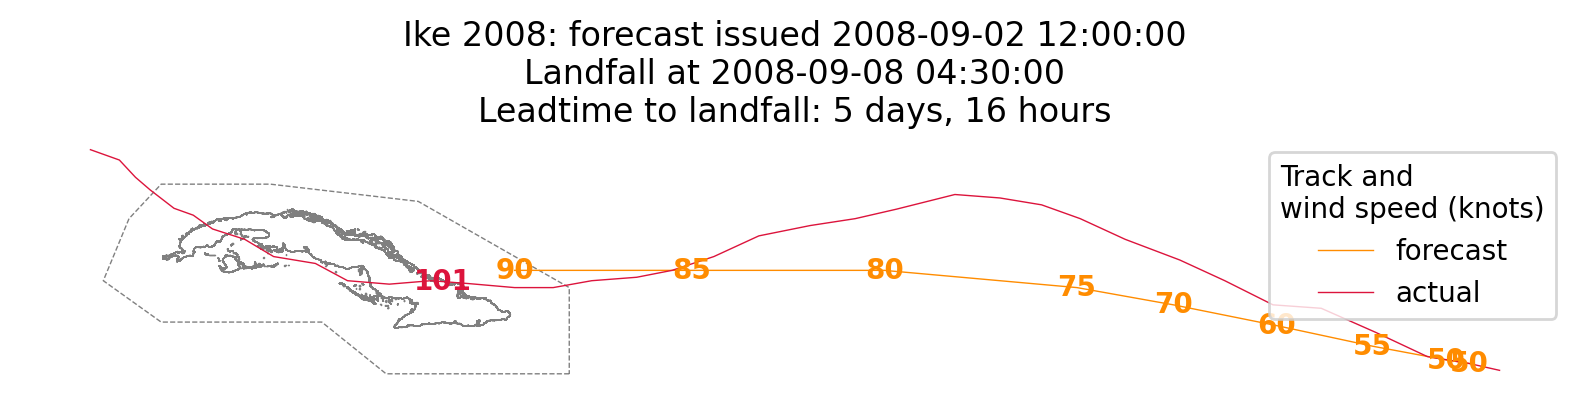

In [191]:
plot_sid_leadtime(IKE)

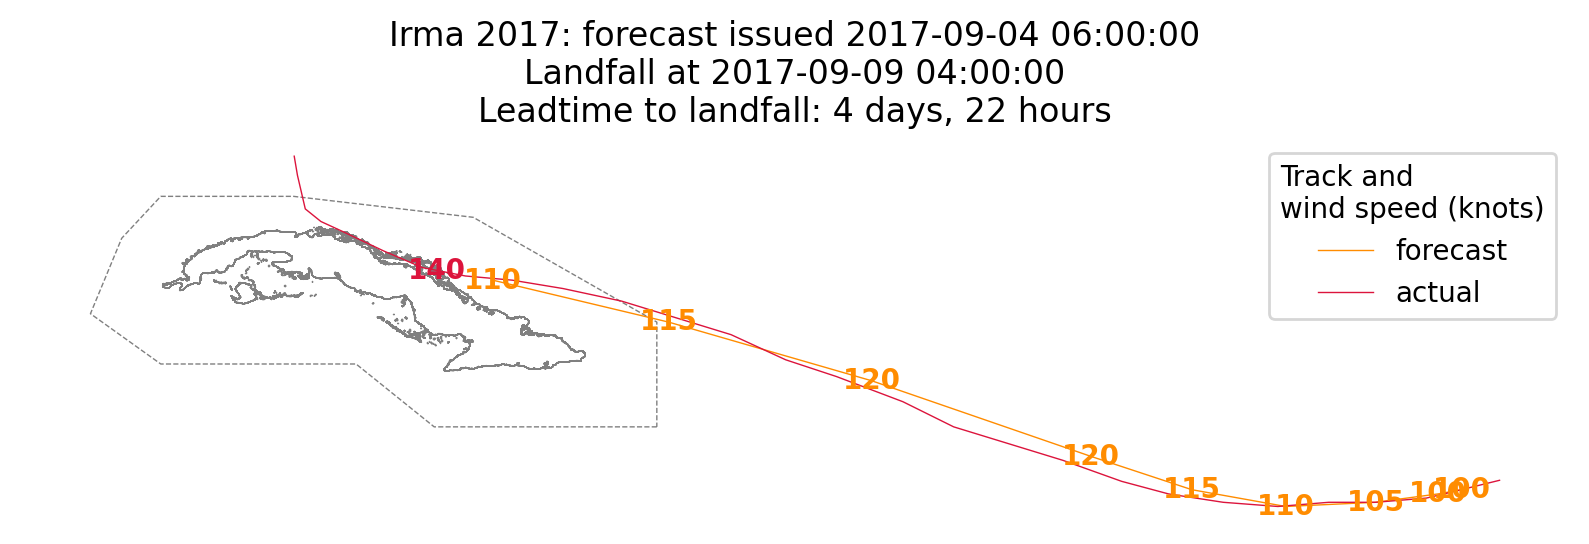

In [192]:
plot_sid_leadtime(IRMA)

In [193]:
# just checking when first ever track forecast was
# and yup, we would've triggered with this first one
gdf_nhc[gdf_nhc["sid"] == OSCAR]["issue_time"].min()

Timestamp('2024-10-19 12:00:00')

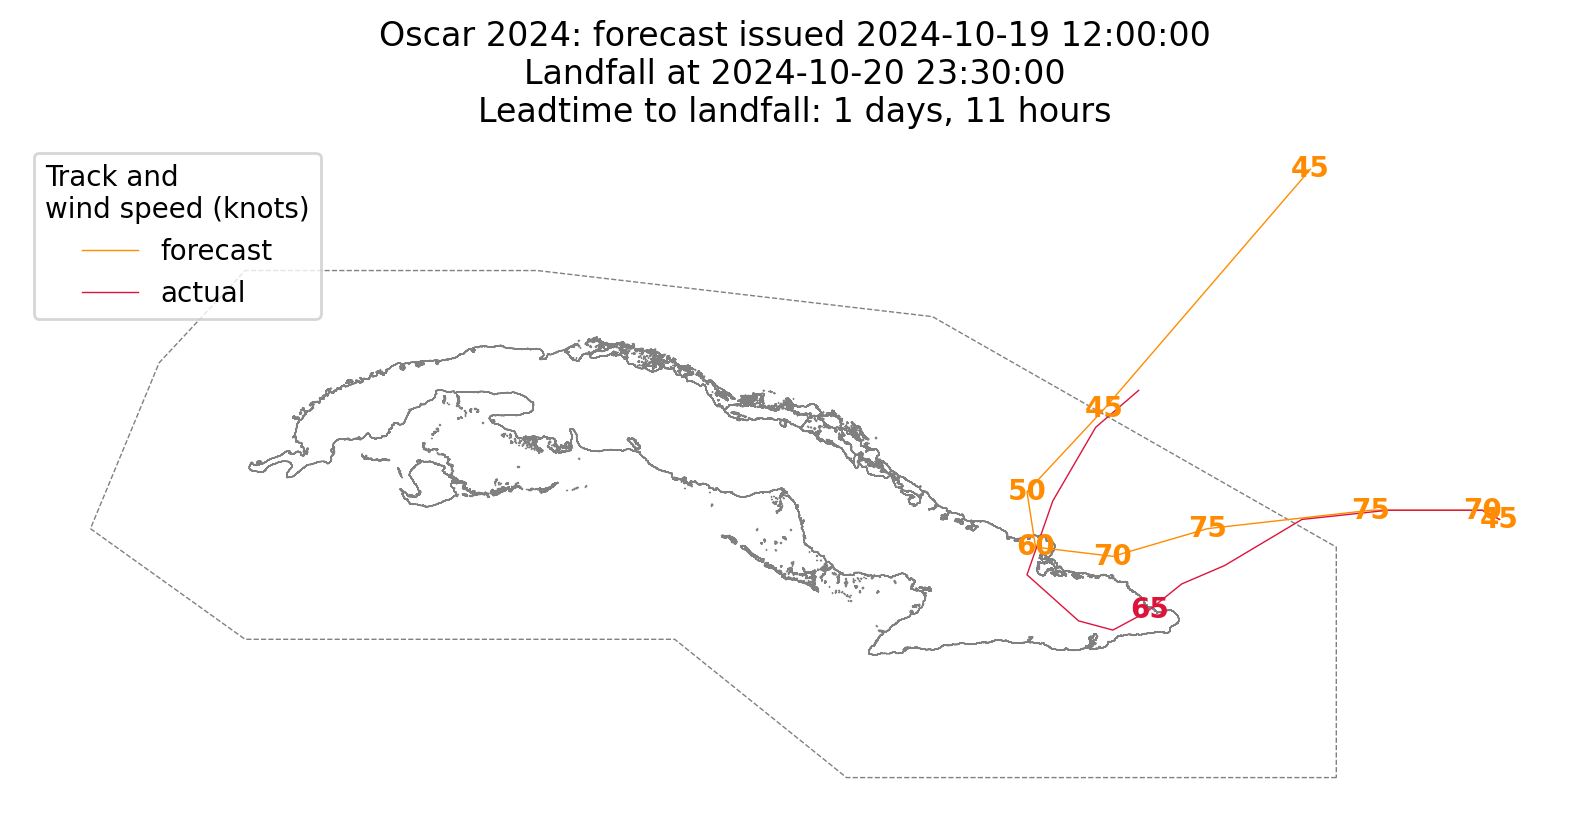

In [194]:
plot_sid_leadtime(OSCAR)

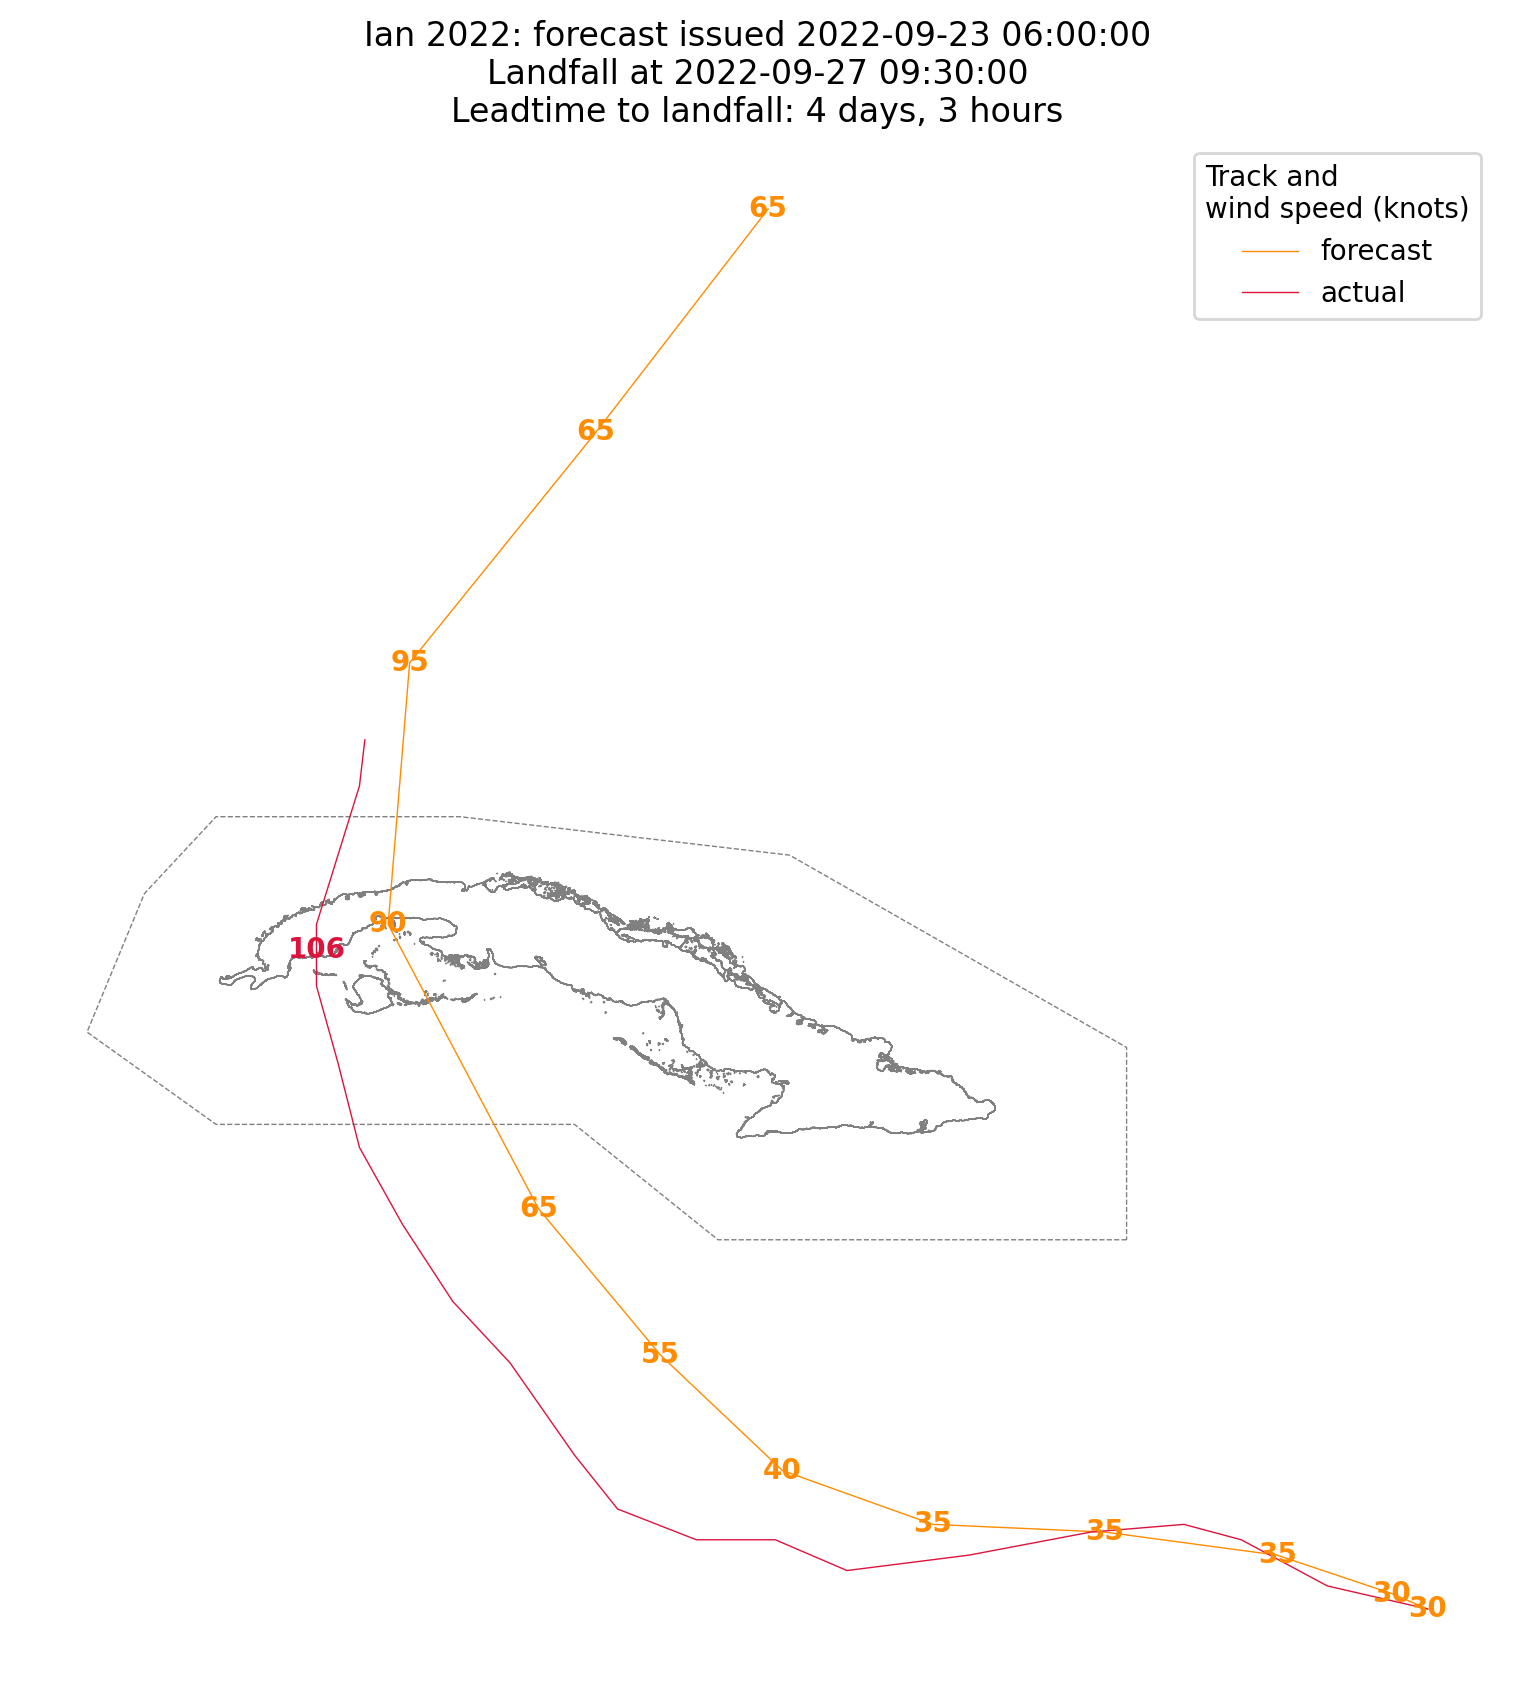

In [195]:
plot_sid_leadtime(IAN)

In [200]:
# same thing - we could've triggered on the first forecast
# so hard to beat that leadtime
gdf_nhc[gdf_nhc["sid"] == RAFAEL]["issue_time"].min()

Timestamp('2024-11-03 18:00:00')

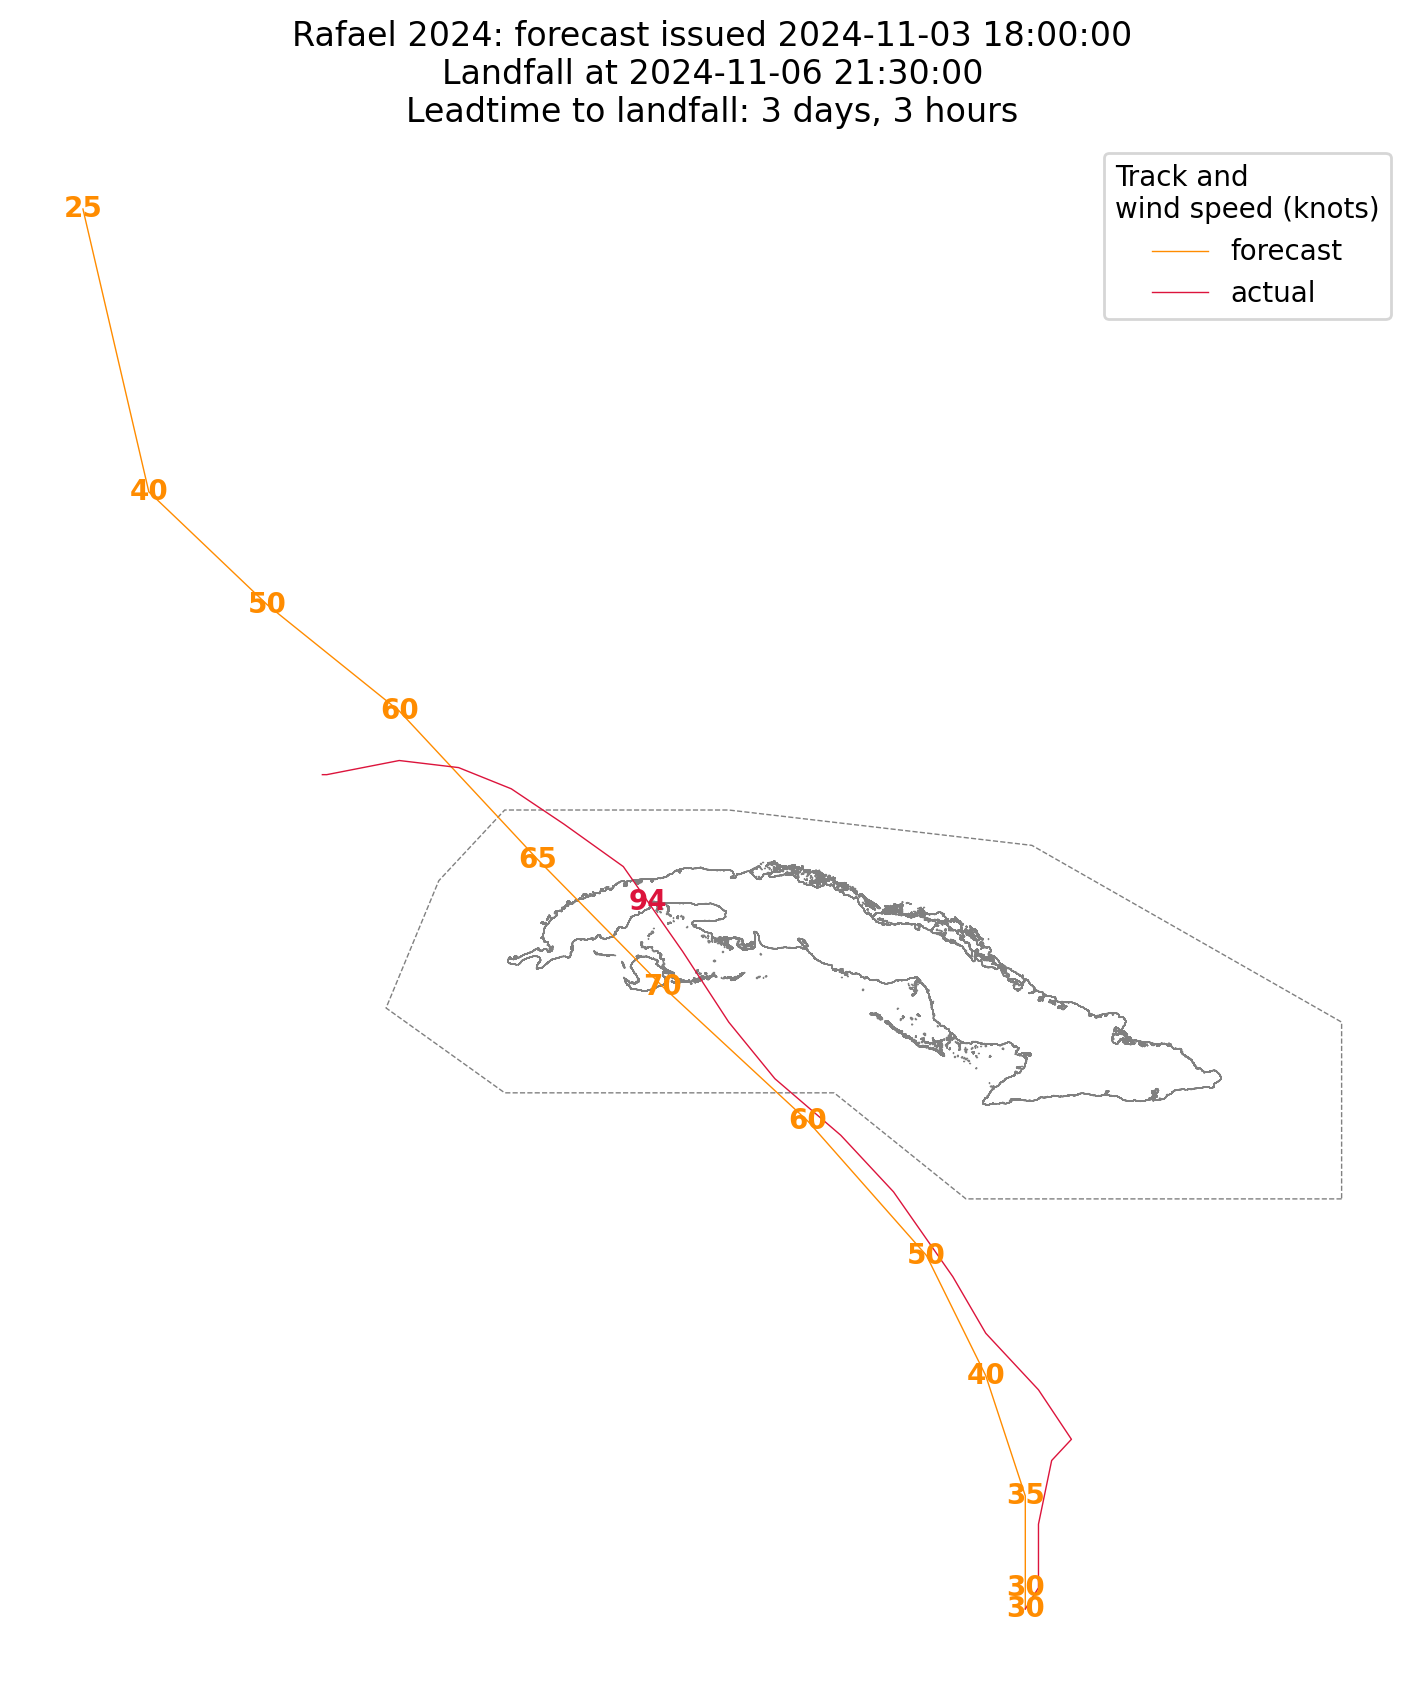

In [201]:
plot_sid_leadtime(RAFAEL)